# Air Passenger Data for Time Series Analysis
There is a list of passenger data from year 1949 to 1960

# Problem Definition
Objective: Predict the number of air passengers for the next 12 months using historical monthly data.

In [330]:
# Import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import autocorrelation_plot



# Load data

We will forecast the number of air passengers for the next 12 months based on historical data using an LSTM model.

In [331]:
# Load data
data = pd.read_csv("C:/Users/PC/OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey/Documents/DeepLearning/AirPassengers.csv")
data.head(10)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


This dataset contains two columns:
* **Month:** in the format YYYY-MM
* **#Passengers:** The number of air passengers

In [332]:
# Convert 'Month' to datetime and set it as index
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

# Rename columns for easier access 
data.rename(columns={"#Passengers": "Passengers"}, inplace=True)


# EDA for time series

In [333]:
# Summary Statistics
summary_stats = data.describe()

# Check Missing Values
missing_values = data.isnull().sum()

# Results
print(summary_stats)
print(missing_values)

       Passengers
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000
Passengers    0
dtype: int64


The standard deviation indicates a significant variance over the period.

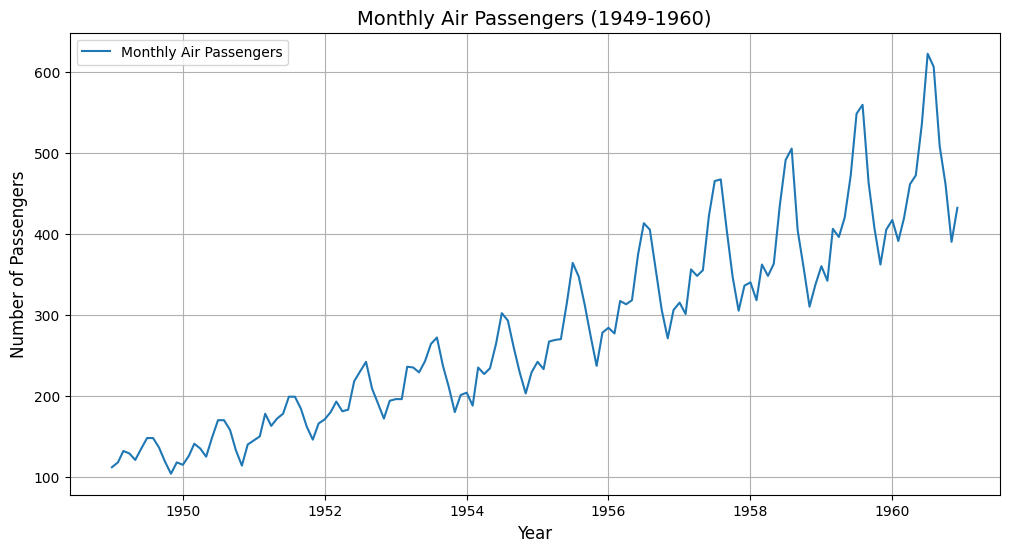

In [334]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Passengers'], label='Monthly Air Passengers')
plt.title('Monthly Air Passengers (1949-1960)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.legend()
plt.grid()
plt.show()

* There is a clear upward trend in the number of passengers over time.
* Seasonal patterns are visible, with peaks and troughs recurring annually.

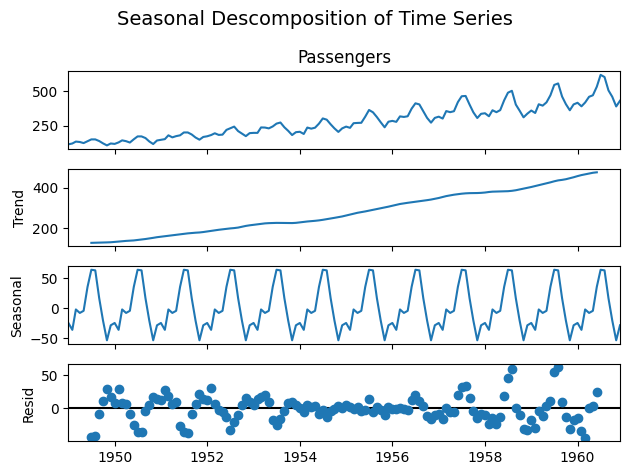

In [335]:
# Seasonality Descomposition
result = seasonal_decompose(data['Passengers'], model = 'additive', period=12)

# Plot descomposition
result.plot()
plt.suptitle('Seasonal Descomposition of Time Series', fontsize=14)
plt.tight_layout()
plt.show()

* **Trend:** Reflects a steady increase in passenger numbers.
* **Seasonal Component:** Highlights recurring patterns within a year.
* **Residuals:** Captures noise and deviations from the expected trend and seasonality.

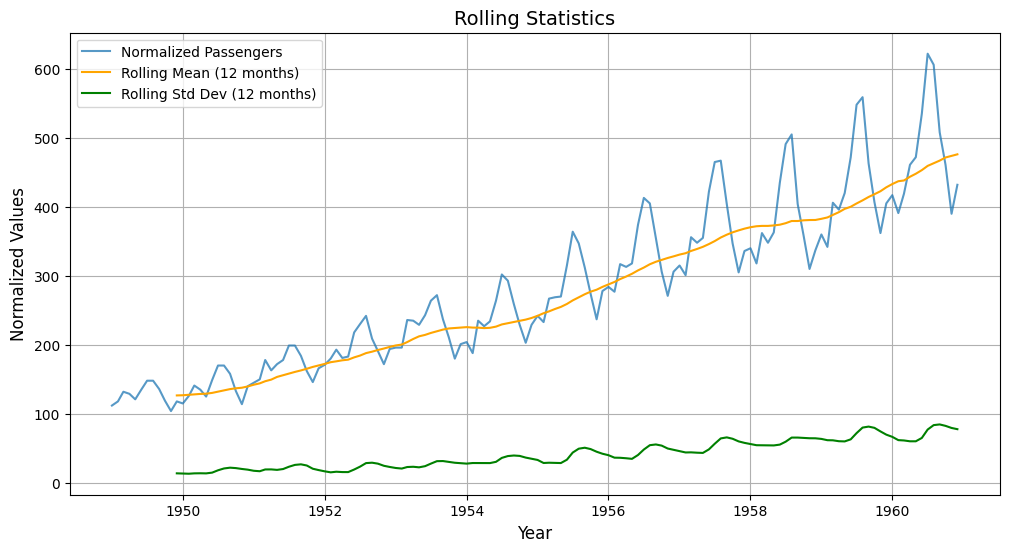

In [336]:
# Rolling Mean and Standard Deviation
rolling_mean = data['Passengers'].rolling(window=12).mean()
rolling_std = data['Passengers'].rolling(window=12).std()

# Plot rolling statistics
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Passengers'], label='Normalized Passengers', alpha=0.75)
plt.plot(data.index, rolling_mean, label='Rolling Mean (12 months)', color='orange')
plt.plot(data.index, rolling_std, label='Rolling Std Dev (12 months)', color='green')
plt.title('Rolling Statistics', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Normalized Values', fontsize=12)
plt.legend()
plt.grid()
plt.show()

**Normalized Passengers**
* Represents the original values of the time series, i.e., the monthly number of passengers. 
* Shows a clear upward trend, indicating that the number of passengers consistenly increases over time.

**Rolling Mean - 12 - Month Moving Average**
* It is the moving average calculated with a 12-month window.
* Its smoothness eliminates seasonal variations, displaying only the overall long-term- trend.
* This line gradually increases, confirming an upward trend in the number of passengers.

**Rolling Std Dev - 12 - Month Moving Standard Deviation**
* Represents the moving standar deviation calculated with a 12-month  window.
* Shows periodic fluctuations (increase and decrease), indicating recurrent seasonal variability.

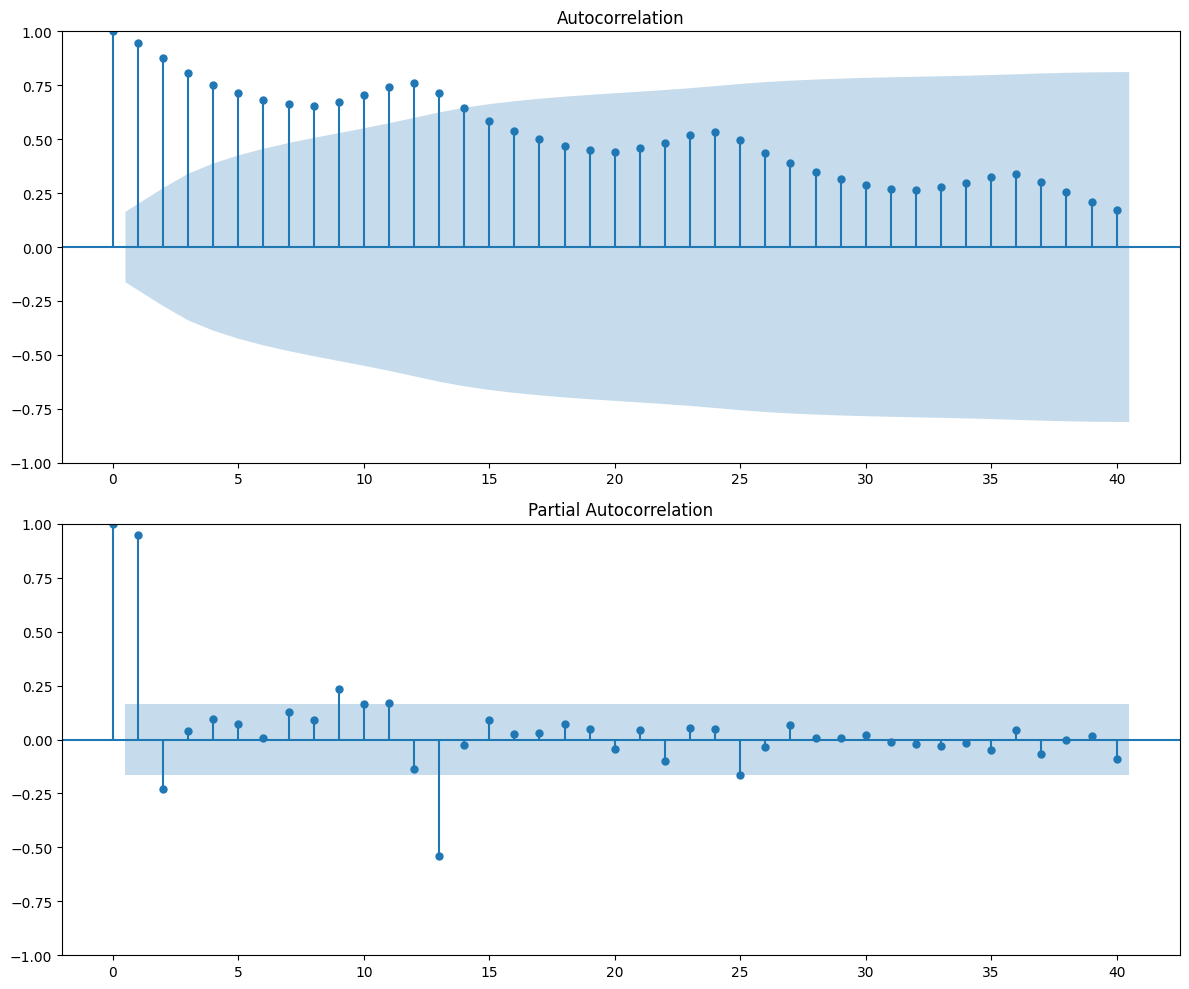

In [337]:
# Autocorrelation and Partial Autocorrelation
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
sm.graphics.tsa.plot_acf(data['Passengers'], lags=40, ax=ax[0], title="Autocorrelation")
sm.graphics.tsa.plot_pacf(data['Passengers'], lags=40, ax=ax[1], title="Partial Autocorrelation")
plt.tight_layout()
plt.show()

**Autocorrelation (ACF):**

* Strong correlations at lags of 12, 24, etc., indicating yearly seasonality.
* Significant correlations at shorter lags reveal dependencies within the same season.

**Partial Autocorrelation (PACF):**

* High partial autocorrelation at lag 1 suggests a strong relationship with the previous month’s values.
* Seasonal lags (e.g., 12) also show notable partial autocorrelation.

# Preparing Data for Modeling

* Normalize data for better model performance.
* Split the data into training and testing sets.
* Create sequences to use as input for the time series model.

In [338]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['Passengers']])

# Convert to numpy array for sequence generation
data_array = data_scaled.flatten()

# Function to create sequences for time series modeling
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence lenght
sequence_length = 12

# Generate sequences
X, y = create_sequences(data_array, sequence_length)

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of training and testing datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((105, 12), (27, 12), (105,), (27,))

* Sequence Length: 12 months (1 year).
* Training Set: 105 samples.
* Testing Set: 27 samples

# Build and Train the LSTM Model

* Defining the model architecture.
* Training the model on the training set.
* Evaluating the model on the test set.

In [339]:
# Reshape input data to 3D (required for LSTM: samples, timesteps, features)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [340]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [341]:
# Define a model to be used with Keras Tuner
def build_model(hp):
    model = Sequential()
    # Add the first LSTM layer with a variable number of units
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32), 
                   activation='relu', 
                   input_shape=(sequence_length, 1)))
    # Add Dropout layer with variable rate
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    # Output layer
    model.add(Dense(1))
    # Compile the model
    model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error'])
    return model

# Set up Keras Tuner for hyperparameter search
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,
    directory='tuning_dir',
    project_name='lstm_tuning'
)

# Run the hyperparameter search
tuner.search(X_train_reshaped, y_train, epochs=50, validation_data=(X_test_reshaped, y_test))

# Get the best hyperparameters and build the final model
best_hps = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hps)


Reloading Tuner from tuning_dir\lstm_tuning\tuner0.json


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


* The architecture of the model uses a Sequential model structure, which allows for a straightforward and clear stacking of layers.

* The LSTM layer is included to capture temporal dependencies and trends within the time series data. The number of units is a hyperparameter that can be tuned to find the optimal capacity for the model to learn from past patterns effectively.

* A Dropout layer follows the LSTM to mitigate overfitting by randomly disabling a fraction of neurons during training. This helps improve the model's generalizability.

* The output layer is a dense layer with a single neuron, which makes sense because the problem requires predicting a single value (i.e., the number of passengers in the next time step).

* The model uses the Adam optimizer due to its adaptive learning rate capability, which is efficient for optimizing LSTM models.

In [342]:
best_model.save('best_lstm_model.h5')

In [343]:
# Compile the final model
best_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
best_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,449 (1.01 MB)

 Trainable params: 264,449 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [344]:
# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs without improvement to stop training
    restore_best_weights=True  # Restore weights from the best epoch
)

# Train the model with Early Stopping
history = best_model.fit(
    X_train_reshaped,
    y_train, 
    epochs=50, 
    batch_size=16, 
    validation_data=(X_test_reshaped, y_test), 
    verbose=1,
    callbacks=[early_stopping]  # Agregar el callback
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.1484 - mean_absolute_error: 0.3259 - val_loss: 0.0438 - val_mean_absolute_error: 0.1601
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0345 - mean_absolute_error: 0.1329 - val_loss: 0.0202 - val_mean_absolute_error: 0.1310
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0225 - mean_absolute_error: 0.1295 - val_loss: 0.0120 - val_mean_absolute_error: 0.0728
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0142 - mean_absolute_error: 0.0859 - val_loss: 0.0077 - val_mean_absolute_error: 0.0640
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0107 - mean_absolute_error: 0.0870 - val_loss: 0.0063 - val_mean_absolute_error: 0.0627
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0107 - mean_absolute_error: 0.0834 - val_loss: 0.0072 - val_mean_absolute_error: 0.0606
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0129 - mean_absolute_error: 0.0795 - val_loss: 0.0050 - va

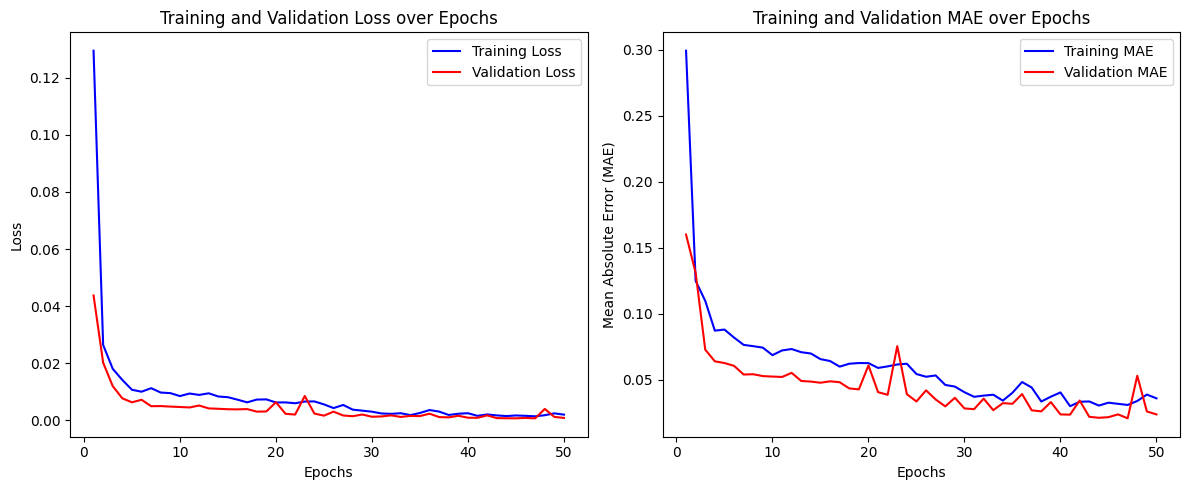

In [345]:
# Plot Training and Validation Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'b', label='Training MAE')
plt.plot(epochs, val_mae, 'r', label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

**Training and Validation Loss over Epochs**

* After around 10 epochs, both losses converge and stay relatively stable, indicating that the model is learning effectively without overfitting.
* Validation Loss is generally lower than Training Loss, which suggests that the model is generalizing well and is not overfitting to the training data. This is a good sign for the model's performance.

**Training and Validation Mae over Epochs**

* The Validation MAE consistently remains lower than the Training MAE, which indicates the model is capable of predicting unseen data well without overfitting.


# Evaluate the model
* Make Predictions: Use the trained model to make predictions on the test set.
* Inverse Transform Predictions: Since the data was scaled, transform the predictions and actual values back to the original scale.
* Calculate Metrics: Compute evaluation metrics like Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE) to assess model performance.

In [346]:
# Make predictions
y_pred = best_model.predict(X_test_reshaped)

# Inverse transform the scaled data
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))


# Calculate evaluation metrics
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = mean_squared_error(y_test_original, y_pred_original, squared=False)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
Mean Absolute Error (MAE): 10.778070520471646
Root Mean Squared Error (RMSE): 14.062660043078235


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


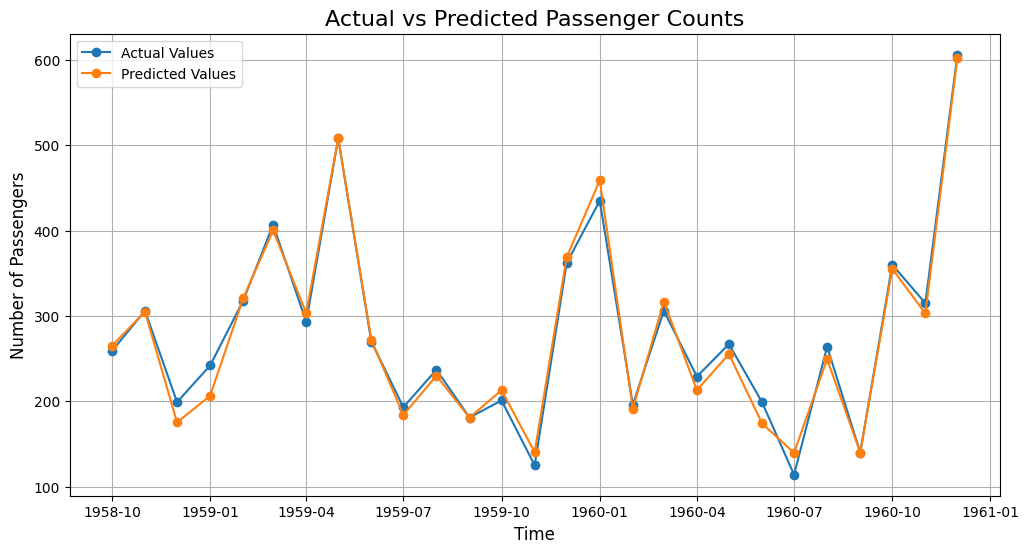

In [347]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test_original, label='Actual Values', marker='o')
plt.plot(data.index[-len(y_test):], y_pred_original, label='Predicted Values', marker='o')
plt.title('Actual vs Predicted Passenger Counts', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


* The model performs well in capturing the seasonal trends and general behavior of the data, as shown by the alignment of the predicted values with the actual passenger counts.
* The predictions follow the overall shape of the actual values, indicating that the LSTM model is effective for forecasting passenger counts with reasonable accuracy.

# Forecasting Future Values

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


C:\Users\PC\AppData\Local\Temp\ipykernel_37188\1834754315.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(data.index[-1], periods=13, freq='M')[1:]


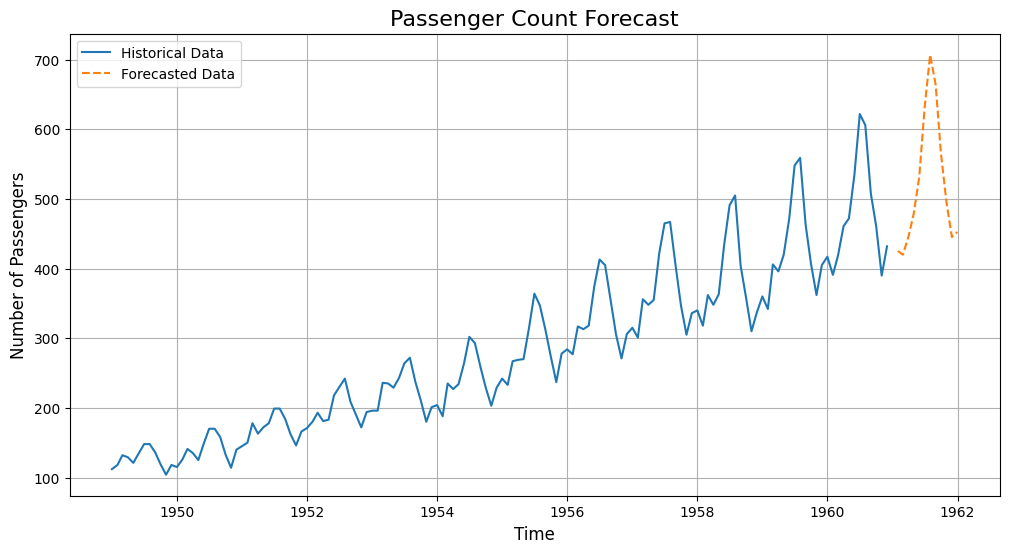

In [348]:
# Use the last sequence from the training set for forecasting
last_sequence = data_array[-sequence_length:].reshape(1, sequence_length, 1)

# Forecast for the next 12 months
future_predictions = []
for _ in range(12):  # 12 months
    next_pred = best_model.predict(last_sequence)  # Predict the next value
    future_predictions.append(next_pred[0, 0])  # Append the predicted value
    # Update the sequence with the predicted value (reshape to match dimensions)
    next_pred_reshaped = np.array(next_pred).reshape(1, 1, 1)
    last_sequence = np.append(last_sequence[:, 1:, :], next_pred_reshaped, axis=1)

# Inverse transform predictions to original scale
future_predictions_original = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot the forecast
future_dates = pd.date_range(data.index[-1], periods=13, freq='M')[1:]
plt.figure(figsize=(12, 6))
plt.plot(data.index, scaler.inverse_transform(data_scaled), label='Historical Data')
plt.plot(future_dates, future_predictions_original, label='Forecasted Data', linestyle='--')
plt.title('Passenger Count Forecast', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()



* The forecasted data for the year 1961 is shown as a dashed orange line.
* The model appears to predict a continuation of the increasing trend observed in the historical data, maintaining the seasonality pattern (i.e., peaks and troughs).
* The forecast also shows some level of variation (rise and fall) similar to what is observed in the historical data, which indicates that the model has learned to replicate the seasonal component.